In [1]:
import pandas as pd
import torch
import torch.nn as nn
import tqdm
import torch.nn.functional as F
import os
import numpy as np
import random
import re
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import math
import torchvision
from IPython.display import display, HTML
from IPython.display import display
display(HTML("<style>.container { width:70% !important; }</style>"))

from useful_functions_notebook_8to13 import *

In [2]:
dataset = torch.load('data/dataset.pt')
dataset = dataset.permute(1, 0, 2, 3)

norm_dataset = torch.load("data/dataset_distlognorm_massnorm.pt")

fake_original = torch.load('data/fake_dataset.pt')

fake_data = torch.load("models/attempt1/generated_images.pt")

six_branches = torch.load('data/six_branch_norm.pt')
six_dataset = six_branches[:, :, :, :6]

fake_data.shape, six_dataset.shape, dataset.shape, fake_original.shape

(torch.Size([8161, 3, 29, 6]),
 torch.Size([8161, 3, 29, 6]),
 torch.Size([38348, 3, 29, 10]),
 torch.Size([38500, 3, 29, 10]))

# mass - monotonicity
- Generated mass should be within the mass range of the original merger trees
- Usually, progenitor masses in a branch are expected to increase monotonically as time (number of row) elapses [3], if not, it is expected to preserve its mass.
    - the deeper in a branch, the more mass it should be
    - a mass branch should increase or stay the same in value the further down in a branch we go
- It is worth noting that the behavior of other variables like progenitor type and distance to main branch affects the expected behavior of the mass assembly history structure and patterns

In [4]:
original_mass = dataset[:, 1]
scaled_mass = norm_dataset[:, 1]

def mass_not_preserved(dataset, threshold = -0.05):
    branches = dataset.shape[-1]

    total_diffs = []

    not_preserving_mass = 0
    total_progenitors = 0

    max_decrease = threshold


    for im in dataset:
        for i in range(branches - 1):
            branch = im[:, i]
            nonzero_values = branch[branch.nonzero()].squeeze(-1)
            total_progenitors += len(nonzero_values)

            if len(nonzero_values) > 1:
                diffs = nonzero_values[1:] - nonzero_values[:-1]
                not_preserved = diffs[diffs < max_decrease]
                not_preserving_mass += len(not_preserved)
                total_diffs.append(diffs.flatten().tolist())
            
    print("\"drastic jump\"threshold = ",max_decrease)
    print(f"number of occurences where mass is not preserved = {not_preserving_mass}")
    print(f"perc of occurences where mass is not preserved = {(100 * not_preserving_mass / total_progenitors):.2f}%")
    print("\n")
    return total_diffs, total_progenitors

print("original dataset with nonzero mass values between 7.64 and 10.98:")
original_total_diffs, total_progenitors = mass_not_preserved(original_mass, threshold = -0.4)
print("log scaled and normalized dataset:")
norm_total_diffs, total_progenitors = mass_not_preserved(scaled_mass, threshold = -0.05)




original dataset with nonzero mass values between 7.64 and 10.98:
"drastic jump"threshold =  -0.4
number of occurences where mass is not preserved = 52068
perc of occurences where mass is not preserved = 2.14%


log scaled and normalized dataset:
"drastic jump"threshold =  -0.05
number of occurences where mass is not preserved = 28581
perc of occurences where mass is not preserved = 1.17%




In [6]:
norm_total_diffs, total_progenitors = mass_not_preserved(scaled_mass, threshold = -0.00001)
original_total_diffs, total_progenitors = mass_not_preserved(original_mass, threshold = -0.00001)

"drastic jump"threshold =  -1e-05
number of occurences where mass is not preserved = 627106
perc of occurences where mass is not preserved = 25.74%


"drastic jump"threshold =  -1e-05
number of occurences where mass is not preserved = 627765
perc of occurences where mass is not preserved = 25.77%




normalized:


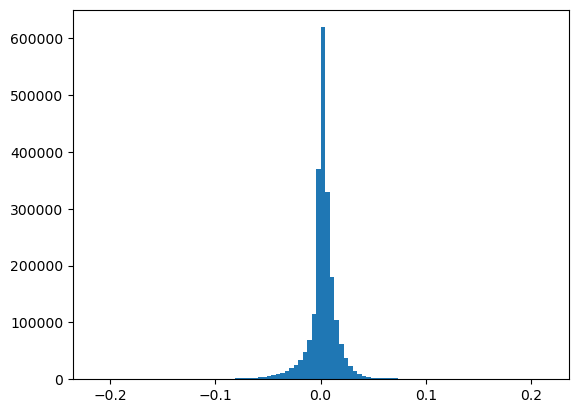

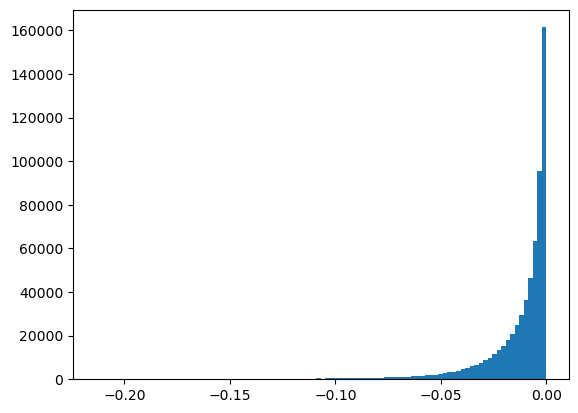

Number of values below threshold: 0.19

original:


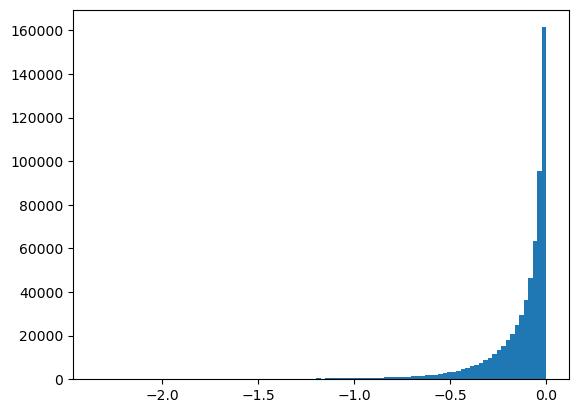

Number of values below threshold: 0.28


In [10]:
print("normalized:")
totals = [item for sublist in norm_total_diffs for item in sublist]
plt.hist(totals, bins = 100)
plt.show()
negative_data = [value for value in totals if value < 0]
plt.hist(negative_data, bins = 100)
plt.show()
threshold = -0.1
# Count the number of values below the threshold
count_below_threshold = sum(1 for value in negative_data if value < threshold)
print("Number of values below threshold:", round(100 * count_below_threshold / total_progenitors, 2))

print("\noriginal:")
totals = [item for sublist in original_total_diffs for item in sublist]
negative_data = [value for value in totals if value < 0]
plt.hist(negative_data, bins = 100)
plt.show()
threshold = -1
# Count the number of values below the threshold
count_below_threshold = sum(1 for value in negative_data if value < threshold)
print("Number of values below threshold:", round(100 * count_below_threshold / total_progenitors, 2))

### with a hard threshold for "drastic jump", there is no good answer of what a drastic jump is. as seen, the decrease in mass has an exponential shape in both datasets. and for the normalized dataset which ranges form 0 - 1, a decrease of 0.1 happens in 20% of all mass steps, which is a lot given that the mass can increase as well

### maybe one option is to look at a "drastic jump" as a percentage decrease

monotonicity threshold = -0.05% change
number of occurences where mass is not preserved = 41765
perc of occurences where mass is not preserved = 1.71%




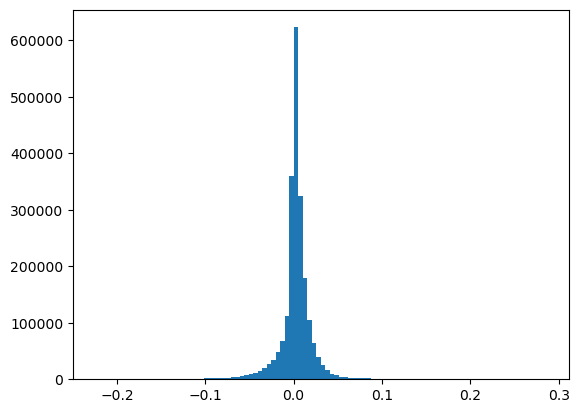

min jump =  tensor(-0.2242)
max jump =  tensor(0.2861)
average jump =  tensor(0.0029)
percentage of mass jumps with a decrease in mass:
monotonicity threshold = -1e-06% change
number of occurences where mass is not preserved = 627774
perc of occurences where mass is not preserved = 25.77%


percentage of mass jumps with a decrease in mass greater than 1%:
monotonicity threshold = -0.01% change
number of occurences where mass is not preserved = 270962
perc of occurences where mass is not preserved = 11.12%


percentage of mass jumps with a decrease in mass greater than 5%:
monotonicity threshold = -0.05% change
number of occurences where mass is not preserved = 41765
perc of occurences where mass is not preserved = 1.71%


percentage of mass jumps with a decrease in mass greater than 10%:
monotonicity threshold = -0.1% change
number of occurences where mass is not preserved = 7701
perc of occurences where mass is not preserved = 0.32%




In [11]:
original_mass = dataset[:, 1]
scaled_mass = norm_dataset[:, 1]

def mass_not_preserved_percentage_decrease(dataset, threshold = -0.05):
    branches = dataset.shape[-1]

    total_diffs = []

    not_preserving_mass = 0
    total_progenitors = 0

    max_decrease = threshold


    for im in dataset:
        for i in range(branches - 1):
            branch = im[:, i]
            nonzero_values = branch[branch.nonzero()].squeeze(-1)
            total_progenitors += len(nonzero_values)

            if len(nonzero_values) > 1:
                diffs = nonzero_values[1:] - nonzero_values[:-1]
                percentage_diffs = diffs / nonzero_values[:-1]
                not_preserved = percentage_diffs[percentage_diffs < max_decrease]
                not_preserving_mass += len(not_preserved)
                total_diffs.append(percentage_diffs.flatten().tolist())
                
    print(f"monotonicity threshold = {max_decrease}% change")
    print(f"number of occurences where mass is not preserved = {not_preserving_mass}")
    print(f"perc of occurences where mass is not preserved = {(100 * not_preserving_mass / total_progenitors):.2f}%")
    print("\n")
    return total_diffs

jumps = mass_not_preserved_percentage_decrease(scaled_mass)

jumps = [item for sublist in jumps for item in sublist]   
j = torch.tensor(jumps)
plt.hist(j.numpy(), bins = 100)
plt.show()
print("min jump = ", j.min())
print("max jump = ", j.max())
print("average jump = ", j.mean())

print("percentage of mass jumps with a decrease in mass:")
original_total_diffs = mass_not_preserved_percentage_decrease(scaled_mass, threshold = -0.000001)
print("percentage of mass jumps with a decrease in mass greater than 1%:")
original_total_diffs = mass_not_preserved_percentage_decrease(scaled_mass, threshold = -0.01)

print("percentage of mass jumps with a decrease in mass greater than 5%:")
original_total_diffs = mass_not_preserved_percentage_decrease(scaled_mass, threshold = -0.05)

print("percentage of mass jumps with a decrease in mass greater than 10%:")
original_total_diffs = mass_not_preserved_percentage_decrease(scaled_mass, threshold = -0.1)

### this is a better way to measure monotonicity in the mass variable. However, 1/4 mass jumps are decreasing in the original training data. 11.12% of the mass jumps decrease with more than 1%, 1.71% decrease with more than 5% and 0.32% of mass jumps decrease with more than 10%. This indicates that monotonicity in the mass variable is not intact in the traning data, therefore it is unfair to put the criterion on the generated data. 

### when that is said, it is still a good measure to make sure the generated data somewhat preserve monotonicity

# Distance
- (1) no set range of distance
- (2) The distance variable should decrease the closer the branch gets to a merge in time. However, there are no set rule for the exact time of occurrence.
- (3) no dramatic jumps - what is a dramastic jump?

In [10]:
# decrease as the snapshot increase, further down the branch
i = random.randint(0, len(dataset))
i = 10000
dataset[i, 0, :, :6]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0313, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0178, 0.0358, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0185, 0.0369, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0167, 0.0376, 0.0000, 0.0550, 0.0000],
        [0.0000, 0.0102, 0.0417, 0.0000, 0.0497, 0.0000],
        [0.0000, 0.0000, 0.0463, 0.0000, 0.0538, 0.0000],
        [0.0000, 0.0000, 0.0449, 0.0000, 0.0579, 0.0532],
        [0.0000, 0.0000, 0.0395, 0.0000, 0.0662, 0.0000],
        [0.0000, 0.0000, 0.0193, 0.0991, 0.0789, 0.0000],
        [0.0000, 0.0000, 0.0113, 0.0991, 0.0907, 0.0000],
        [0.0000, 0.0000, 0.0107, 0.0853, 0.0919, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0853, 0.0944, 0.0000],
        [0.000

#### inspecting distance, we see that the distance to the main branch decrease the closer the branch gets to the merge in time (last nonzero element in a branch), however, this is not consistent. In many branches, the distance increase first, then decrease. In branch 5, the distance start at 0.0550, decresae to 0.497, then increase up to 0.964, then decrease all the way back to 0.475. There is no clear linear or continuous decreasing in distance to the mian branch.

#### one feature worth noting is that the last nonzero value (merging event) is the lowest distance to the main branch in each branch. so that is something worth checking.

In [9]:
# last distance to main branch before a merging event is the smallest
distance = dataset[:, 0, :, 1:]
branches = distance.shape[-1]

total_merger_distance_fail = 0

for im in distance:
    
    for i in range(branches):
        
        branch = im[:, i]
        nonzero_values = branch[branch.nonzero()].squeeze(-1)
        if len(nonzero_values) > 0:
            minimum_branch = nonzero_values.min()
        
            last = nonzero_values[-1]
        else:
            continue
        
        if last != minimum_branch:
            total_merger_distance_fail += 1
        
print("total branches where the last halo distance to main branche is not the lowest in the branch is = ", total_merger_distance_fail)
perc = round(100 * total_merger_distance_fail / (branches * len(distance)), 2)
print("percentage of all branches where the last halo distance to main branche is not the lowest in the branch is = ", perc)

total branches where the last halo distance to main branche is not the lowest in the branch is =  61705
percentage of all branches where the last halo distance to main branche is not the lowest in the branch is =  17.88


total distance progentors = 1479606 
number of occurences where distance increase (not preserved) = 736753
perc of occurences where mass increase (not preserved) = 49.79%


total branches where the last halo distance to main branche is not the lowest in the branch is =  59650
percentage of all branches where the last halo distance to main branche is not the lowest in the branch is =  17.28




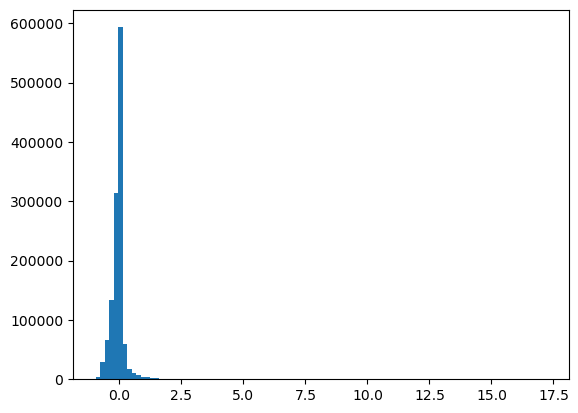

min jump =  tensor(-0.9657)
max jump =  tensor(17.2160)
average jump =  tensor(-0.0593)
Values above the 1: 0.88889%
Values above the 0.5: 6.585%
Values above the 0.4: 10.16%
Values above the 0.3: 15.43%
Values above the 0.2: 23.55%
Values above the 0.15: 29.69%
Values above the 0.1: 39.00%


In [16]:
# dramastic jump
distance = dataset[:, 0, :, 1:]
branches = distance.shape[-1]

def distance_drastic_jumps(dataset):
    branches = dataset.shape[-1]

    total_diffs = []
    
    not_preserved_dist = 0
    total_progenitors = 0

    #max_decrease = threshold
    
    total_merger_distance_fail = 0


    for im in dataset:
        for i in range(branches - 1):
            branch = im[:, i]
            nonzero_values = branch[branch.nonzero()].squeeze(-1)
            total_progenitors += len(nonzero_values)

            if len(nonzero_values) > 1:
                diffs = nonzero_values[1:] - nonzero_values[:-1]
                percentage_diffs = diffs / nonzero_values[:-1]
                not_preserved = percentage_diffs[percentage_diffs < 0.0]
                not_preserved_dist += len(not_preserved)
                total_diffs.append(percentage_diffs.flatten().tolist())
                
                minimum_branch = nonzero_values.min()
                last = nonzero_values[-1]
                if last != minimum_branch:
                    total_merger_distance_fail += 1
                
    print(f"total distance progentors = {total_progenitors} ")
    print(f"number of occurences where distance increase (not preserved) = {not_preserved_dist}")
    print(f"perc of occurences where mass increase (not preserved) = {(100 * not_preserved_dist / total_progenitors):.2f}%")
    print("\n")
    print("total branches where the last halo distance to main branche is not the lowest in the branch is = ", total_merger_distance_fail)
    perc = round(100 * total_merger_distance_fail / (branches * len(distance)), 2)
    print("percentage of all branches where the last halo distance to main branche is not the lowest in the branch is = ", perc)
    print("\n")
    return total_diffs, total_progenitors

jumps, total_progenitors = distance_drastic_jumps(distance)

jumps = [item for sublist in jumps for item in sublist]   
j = torch.tensor(jumps)
plt.hist(j.numpy(), bins = 100)
plt.show()
print("min jump = ", j.min())
print("max jump = ", j.max())
print("average jump = ", j.mean())



abs_j = torch.abs(j)

threshold = 1
# Boolean indexing to get values above the threshold
values_above_threshold = abs_j[abs_j > threshold]
print(f"Values above the {threshold}: {100 * (len(values_above_threshold) / (total_progenitors)):.5f}%")


threshold = 0.5
# Boolean indexing to get values above the threshold
values_above_threshold = abs_j[abs_j > threshold]
print(f"Values above the {threshold}: {100 * (len(values_above_threshold) / (total_progenitors)):.3f}%")


threshold = 0.4
# Boolean indexing to get values above the threshold
values_above_threshold = abs_j[abs_j > threshold]
print(f"Values above the {threshold}: {100 * (len(values_above_threshold) / (total_progenitors)):.2f}%")


threshold = 0.3
# Boolean indexing to get values above the threshold
values_above_threshold = abs_j[abs_j > threshold]
print(f"Values above the {threshold}: {100 * (len(values_above_threshold) / (total_progenitors)):.2f}%")

threshold = 0.2
# Boolean indexing to get values above the threshold
values_above_threshold = abs_j[abs_j > threshold]
print(f"Values above the {threshold}: {100 * (len(values_above_threshold) / (total_progenitors)):.2f}%")

threshold = 0.15
# Boolean indexing to get values above the threshold
values_above_threshold = abs_j[abs_j > threshold]
print(f"Values above the {threshold}: {100 * (len(values_above_threshold) / (total_progenitors)):.2f}%")


threshold = 0.1
# Boolean indexing to get values above the threshold
values_above_threshold = abs_j[abs_j > threshold]
print(f"Values above the {threshold}: {100 * (len(values_above_threshold) / (total_progenitors)):.2f}%")

total distance progentors = 1479606 
number of occurences where distance increase (not preserved) = 736753
perc of occurences where mass increase (not preserved) = 49.79%


total branches where the last halo distance to main branche is not the lowest in the branch is =  59650
percentage of all branches where the last halo distance to main branche is not the lowest in the branch is =  17.28




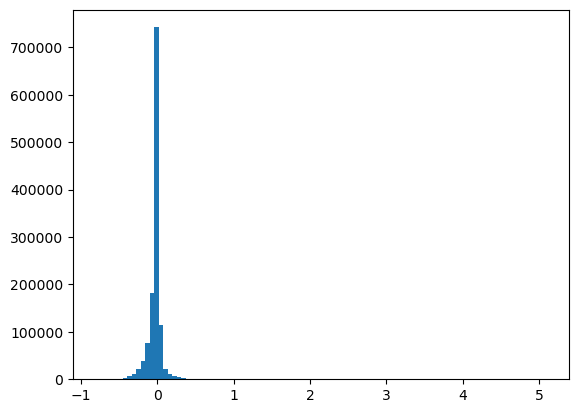

min jump =  tensor(-0.8070)
max jump =  tensor(5.0933)
average jump =  tensor(-0.0260)
Values above the 1: 0.00237%
Values above the 0.5: 0.155%
Values above the 0.4: 0.52%
Values above the 0.3: 1.65%
Values above the 0.2: 4.76%
Values above the 0.15: 7.91%
Values above the 0.1: 13.42%


In [15]:
# dramastic jump
distance = norm_dataset[:, 0, :, 1:]
branches = distance.shape[-1]

jumps, total_progenitors = distance_drastic_jumps(distance)

jumps = [item for sublist in jumps for item in sublist]             

j = torch.tensor(jumps)
plt.hist(j.numpy(), bins = 100)
plt.show()
print("min jump = ", j.min())
print("max jump = ", j.max())
print("average jump = ", j.mean())

abs_j = torch.abs(j)

threshold = 1
# Boolean indexing to get values above the threshold
values_above_threshold = abs_j[abs_j > threshold]
print(f"Values above the {threshold}: {100 * (len(values_above_threshold) / (total_progenitors)):.5f}%")


threshold = 0.5
# Boolean indexing to get values above the threshold
values_above_threshold = abs_j[abs_j > threshold]
print(f"Values above the {threshold}: {100 * (len(values_above_threshold) / (total_progenitors)):.3f}%")


threshold = 0.4
# Boolean indexing to get values above the threshold
values_above_threshold = abs_j[abs_j > threshold]
print(f"Values above the {threshold}: {100 * (len(values_above_threshold) / (total_progenitors)):.2f}%")


threshold = 0.3
# Boolean indexing to get values above the threshold
values_above_threshold = abs_j[abs_j > threshold]
print(f"Values above the {threshold}: {100 * (len(values_above_threshold) / (total_progenitors)):.2f}%")

threshold = 0.2
# Boolean indexing to get values above the threshold
values_above_threshold = abs_j[abs_j > threshold]
print(f"Values above the {threshold}: {100 * (len(values_above_threshold) / (total_progenitors)):.2f}%")

threshold = 0.15
# Boolean indexing to get values above the threshold
values_above_threshold = abs_j[abs_j > threshold]
print(f"Values above the {threshold}: {100 * (len(values_above_threshold) / (total_progenitors)):.2f}%")


threshold = 0.1
# Boolean indexing to get values above the threshold
values_above_threshold = abs_j[abs_j > threshold]
print(f"Values above the {threshold}: {100 * (len(values_above_threshold) / (total_progenitors)):.2f}%")

### (1) no need to include in evaluation

### (2) hard to use in an evaluation since the percentage of branches where the last halo is not the lowest distance to the main branch is 17.88% in the training data. This is not really a way to check for consistency where almost 1 in every 5 branch fails this criteria. However, it is possible to keep in mind and make sure the percentage in the generated trees are not significantly higher

### additionally, 50% of the distance jumps are increasing, which is contradictory to "The distance variable should decrease the closer the branch gets to a merge in time"

### (3) what is a drastic jump? using the original dataset, the lowest decresaing jump is og 96.57% decrease, while the biggest increase jump is 1700.2% increase in distance. 0.88% of distance jumps have a change (positive or negative) with more than 100% and 39% of the jumps has a change of more than 10%. these big numbers are most likely due to the low distance variables in the original dataset. small numerical changes will lead to big percentage changes

### using the normalized data the lowest decresaing jump is og 80.07% decrease, while the biggest increase jump is 500.1% increase in distance. 0.00237% of distance jumps have a change (positive or negative) with more than 100% and 13.42% of the jumps has a change of more than 10%.

### using this results, a "drastic jump" can be qualified as a 20% or more change in the distance value (negative or positive change). This corresponds to less than 5% of the distance jumps in the normalized dataset.

### since these "drastic jump" rate is fairly high, the drastic distance jump should not be used as a strict metric, but as a guidline.

# Subhalo
- (1) In the main branch, progenitor types are expected to be main haloes. There are a few exceptions early in time
- (2) In other branches, the progenitor types can be both main halo or satellite/subhalo. Usually, progenitors become satellites as they approach the other merging halo, as a result of gravitational infall

tensor([0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 0.5000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000], dtype=torch.float64)
(tensor([14, 15]),)
number of trees with subhalo in main branch later than 25 = 1824
Percentage of trees with subhalo in main branch later than 25 : 4.76


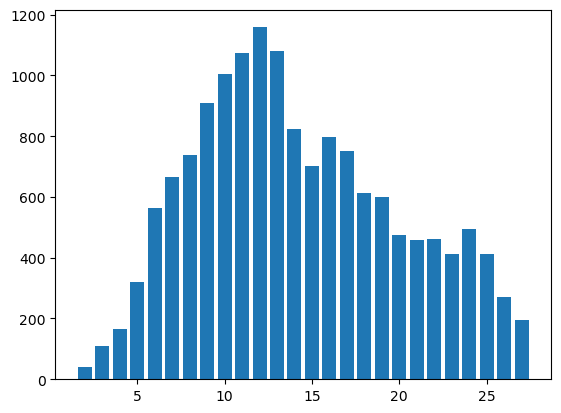

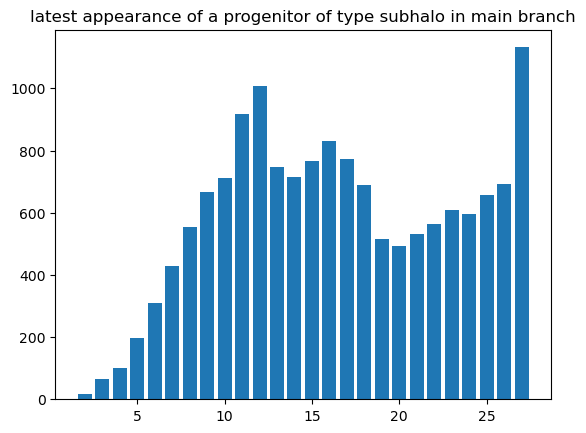

In [14]:
subhalo = norm_dataset[:, 2]
main_branch = subhalo[:, :, 0]

value = 0.5
earliest = []
latest = []
late05 = 0

for i, tensor in enumerate(main_branch):
    # Find indices where the value occurs
    indices = torch.where(tensor == value)
    if i == 4:
        print(tensor)
        print(indices)
    

    # If the value exists in the tensor
    if len(indices[0]) > 0:
        # Find the minimum index (earliest appearance)
        earliest_appearance_index = indices[0].min()
        latest_appearance_index = indices[0].max()
        earliest.append(earliest_appearance_index)
        latest.append(latest_appearance_index)
        if latest_appearance_index > 25:
            late05 += 1
            
print("number of trees with subhalo in main branch later than 25 =",late05)
print("Percentage of trees with subhalo in main branch later than 25 :", round(late05 * 100 / len(main_branch), 2))
        
unique_values_early, counts_early = np.unique(earliest, return_counts=True)
unique_values_late, counts_late = np.unique(latest, return_counts=True)
plt.bar(unique_values_early, counts_early)
plt.show()
plt.bar(unique_values_late, counts_late)
plt.title("latest appearance of a progenitor of type subhalo in main branch")
plt.show()
            
#print(earliest, i)

In [53]:
def subhalo_last_type_is_sattelite(dataset):
    branches = dataset.shape[-1]

    not_preserving_subhalo = 0
    total_branches = 0
    for im in dataset:
        for i in range(branches - 1):
            branch = im[:, i + 1]
            nonzero_values = branch[branch.nonzero()].squeeze(-1)
            total_branches += 1

            if len(nonzero_values):
                if nonzero_values[-1] != 0.5:
                    not_preserving_subhalo += 1
                
    print(f"perc of branches where last progenitor type is not subhalo = {(100 * not_preserving_subhalo / total_branches):.2f}%")
    print("\n")
    return

In [54]:
subhalo = norm_dataset[:, 2]
subhalo_last_type_is_sattelite(subhalo)

perc of branches where last progenitor type is not subhalo = 14.52%




### (1) - no need to deal with in evaluation: No need to check further on subhalo in main branch, since yes most of the subhaloes in the main branch is main haloes, and some are subhaloes. However, the subhaloes does not just appear in early snapshots as stated in the paper. In fact the most freqent last subhalo in the main branch is at snapshot 27. 5% of merger trees has subhalo in main branch later than snapshot 25

### (2) - since the progenitor type can be both main/sattelite, there is no need to check this. "usually" doesnt mean that any earlier subhaloes, however, it is worth keeping in mind that the lower haloes in a branch can be subhaloes. This means a more green-ish color (green is subhalo, blue is main halo)

# conclusion:
## - subhalo: no need to evaluate or deal with
## - distance: 
    - possible to check that the last progenitor is the closest to the main branch (but not a huge requirement or strict rule), 17.88% of the training data is inconsistent in terms of this. 
    - additionally, 50% of the distance jumps increase, which is contradictory to "The distance variable should decrease the closer the branch gets to a merge in time"
    - "drastic jumps" are qualified as a 20% or higher change (negative or positive) in a distance jump on the normalized distance variable. Not a strict requirement for evaluation since 5% of the normalized distance value have jumps higher than this ranging up to a 500% change.
## - mass:
    - mass not preserved = decrease by more than 1% in a mass jump. However, this mass monotonicity is not preserved in the original data, so it is not a strict requirement. however, worth checking.
    

In [3]:

variable_consistancy_check(norm_dataset, False)


MASS:
monotonicity threshold = -1e-06% change
number of occurences where mass is not preserved = 627774
perc of occurences where mass is not preserved = 25.77% vs. 25.77% in training data




monotonicity threshold = -0.01% change
number of occurences where mass is not preserved = 270962
perc of occurences where mass is not preserved = 11.12% vs. 11.12% in training data




monotonicity threshold = -0.05% change
number of occurences where mass is not preserved = 41765
perc of occurences where mass is not preserved = 1.71% vs. 1.71% in training data




monotonicity threshold = -0.1% change
number of occurences where mass is not preserved = 7701
perc of occurences where mass is not preserved = 0.32% vs. 0.32% in training data







DISTANCE:
total distance progentors = 1518348 
number of occurences where distance increase (not preserved) = 754149
perc of occurences where mass increase (not preserved) = 49.67% vs. 49.67% in training data


total branches where the last halo distance to 

In [5]:
variable_consistancy_check(six_dataset, False)

MASS:
monotonicity threshold = -1e-06% change
number of occurences where mass is not preserved = 89776
perc of occurences where mass is not preserved = 22.67% vs. 25.77% in training data




monotonicity threshold = -0.01% change
number of occurences where mass is not preserved = 36826
perc of occurences where mass is not preserved = 9.30% vs. 11.12% in training data




monotonicity threshold = -0.05% change
number of occurences where mass is not preserved = 6336
perc of occurences where mass is not preserved = 1.60% vs. 1.71% in training data




monotonicity threshold = -0.1% change
number of occurences where mass is not preserved = 1180
perc of occurences where mass is not preserved = 0.30% vs. 0.32% in training data







DISTANCE:
total distance progentors = 266699 
number of occurences where distance increase (not preserved) = 133606
perc of occurences where mass increase (not preserved) = 50.10% vs. 49.67% in training data


total branches where the last halo distance to main 

In [6]:
variable_consistancy_check(fake_original, False)

MASS:
monotonicity threshold = -1e-06% change
number of occurences where mass is not preserved = 1199076
perc of occurences where mass is not preserved = 32.70% vs. 25.77% in training data




monotonicity threshold = -0.01% change
number of occurences where mass is not preserved = 734231
perc of occurences where mass is not preserved = 20.03% vs. 11.12% in training data




monotonicity threshold = -0.05% change
number of occurences where mass is not preserved = 444697
perc of occurences where mass is not preserved = 12.13% vs. 1.71% in training data




monotonicity threshold = -0.1% change
number of occurences where mass is not preserved = 420930
perc of occurences where mass is not preserved = 11.48% vs. 0.32% in training data







DISTANCE:
total distance progentors = 1650500 
number of occurences where distance increase (not preserved) = 853862
perc of occurences where mass increase (not preserved) = 51.73% vs. 49.67% in training data


total branches where the last halo distan